In [ ]:
import sys
import os
import numpy as np
import pandas as pd

## Load Data

In [ ]:
# If it is not downloading we need to go to google drive which you will find on trello and copy part of the link with the id for the file
# After download file should show up on the left side in folder/files
!gdown --id 1uPnQEVYnMxVtT9YpDqL_6nRAUKBLYJAM

Downloading...
From: https://drive.google.com/uc?id=1uPnQEVYnMxVtT9YpDqL_6nRAUKBLYJAM
To: /content/random-10m.txt
95.3MB [00:00, 123MB/s] 


In [ ]:
EMPTY_LETTER = "X"
LETTERS_KEYBOARD = ["`","~", "1","!", "2","@", "3","#", "4","$", "5","%", "6","^", "7","&", "8","*", "9","(", "0",")", "-","_", "=","+",
                    "q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "[","{", "]","}",
                    "a", "s", "d", "f", "g", "h", "j", "k", "l", ";",":", "'","\"", "\\","|",
                    "z", "x", "c", "v", "b", "n", "m", ",","<", ".",">", "/","?"]

KEYBOARD_LAYOUT_QWERTY = [["`~", "1!", "2@", "3#", "4$", "5%", "6^", "7&", "8*", "9(", "0)", "-_", "=+"],
                          [EMPTY_LETTER, "q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "[{", "]}"],
                          [EMPTY_LETTER, "a", "s", "d", "f", "g", "h", "j", "k", "l", ";:", "'\"", "\\|"],
                          [EMPTY_LETTER, "z", "x", "c", "v", "b", "n", "m", ",<", ".>", "/?", EMPTY_LETTER, EMPTY_LETTER],
                          [EMPTY_LETTER,EMPTY_LETTER, " ", " ", " ", " ", " ", " ", " ", EMPTY_LETTER, EMPTY_LETTER, EMPTY_LETTER, EMPTY_LETTER]]

KEYBOARD_LAYOUT_QWERTY = np.asarray(KEYBOARD_LAYOUT_QWERTY)

In [ ]:
path = "random-10m.txt"
pass_list = []

with open(path,'r', encoding='utf-8') as file:
    pass_list = [line.replace("\n","") for line in file]

df_passwords = pd.DataFrame(pass_list)
df_passwords = df_passwords.rename(columns={0: "passwords"})

In [ ]:
df_passwords.head()

,passwords
0,112233445566
1,fox777
2,pakistan11
3,keith
4,bN8dK0


In [ ]:
"1" in LETTERS_KEYBOARD

True

In [ ]:
import unicodedata as ud
import regex as re



def is_latin(uchr, latin_letters):
    """
    Check if letter is in latin alphabet
    """
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    """
    Check if string is written in lating alphabet
    """
    latin_letters = {}
    unistr = unistr.lower()
    is_roman = all(is_latin(uchr, latin_letters) for uchr in unistr
                   if uchr.isalpha())
    return is_roman

def is_on_keyboard(unistr):
    unistr = unistr.lower()
    is_keyboard_char = all(uchr in LETTERS_KEYBOARD for uchr in unistr)
                   
    return is_keyboard_char

def is_password_email(unistr):
  password = unistr
  regex = '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$'
  if re.search(regex, password):  
        return True
  else:  
        return False

def is_password_too_long(unistr, length=128):
  if len(unistr) > 128:
    return True
  else:
    return False


def is_password_correct(unistr):
  password = unistr.values[0]
  is_keyboard = is_on_keyboard(password)
  is_email = is_password_email(password)
  is_long = is_password_too_long(password)

  if is_keyboard and not is_email and not is_long:
    return True
  else:
    return False


In [ ]:
 df_passwords_bool = df_passwords.apply(is_password_correct, axis=1)

In [ ]:
df_passwords_bool.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [ ]:
df_passwords = df_passwords[df_passwords_bool == True].reset_index(drop=True)

In [ ]:
df_passwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9881981 entries, 0 to 9881980
Data columns (total 1 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   passwords  object
dtypes: object(1)
memory usage: 75.4+ MB


In [ ]:
df_passwords.isnull().sum()

passwords    0
dtype: int64

In [ ]:
# df_passwords.iloc[210:260]

## EDA

In [ ]:
df_passwords["length"] = df_passwords.passwords.map(len)

In [ ]:
df_passwords[df_passwords["length"] > 128]

,passwords,length


In [ ]:
max_lenght = df_passwords.length.max()

In [ ]:
def compute_distribution_for_places(password, dict_compute):
  for idx, sign in enumerate(password):
    try: 
      dict_compute[idx][sign] += 1
    except KeyError:
      dict_compute[idx][sign] = 1
  return dict_compute

def analyze_password_place( df: pd.DataFrame, max_lenght:int) -> dict:
  dict_comput = {idx: {} for idx in range(max_lenght)}
  for row in df.itertuples(index=False):
    dict_comput = compute_distribution_for_places(row.passwords, dict_comput)

  return dict_comput

In [ ]:
dict_comput = analyze_password_place( df_passwords, max_lenght)


In [ ]:
df_compute = pd.DataFrame.from_dict(dict_comput)

## Passwords to vectors



In [ ]:
def create_keyboard_layout_position_dict(keyboard_layout: np.ndarray,
                                         empty_letter: str = "X",
                                         layout: str = "QWERTY") -> dict:
    """
    Create dictionary with keys as signs and values as indices of those keys in
    the keyboard_layout.
    In case you use different layout then QWERTY probably you should adjust
    indices for space " ".

    Parameters
    ----------
    keyboard_layout: np.ndarray
        Keyboard layout as numpy array. If it is uneven is should be filled
        with empty_letters to achive the same length of every row.
    empty_letter: str
        Filling of keyboard_layout in case of uneven rows.
    layout: str
        Type of keyboard layout

    Returns
    -------
    out: dict
        Dictionary with indices for signs form keyboard

    """
    position_dict = {}
    for idx, x in np.ndenumerate(keyboard_layout):
        if x == empty_letter:
            continue
        if x == " " and layout == "QWERTY":
            shape = keyboard_layout.shape
            try:
                position_dict[x] = (idx[0], shape[1] // 2) # idx[0] row, shape[1] // 2 - middle of row
            except KeyError:
                continue
        if len(x) > 1:
            position_dict[x[0]] = idx
            position_dict[x[1]] = idx
        else:
            position_dict[x] = idx
    return position_dict

def cast_password_to_vector(password: str, position_dict: str) -> np.ndarray:
    """
    Creates vector from password based on the dict with keys as 
    letters and values as their index on keyboard
    
    Parameters
    ----------
    password: str
        Well password is a password
    position_dict:dict
        Dictionary with keys as signs and values as indices of those keys in
        the keyboard_layout.

    Returns
    -------
    out: np.ndarray
        Vector of password
    """
    password = password.lower()
    vector = np.asarray([position_dict[letter] for letter in password])
    vector = np.sum(vector, axis=0)
    return vector

In [ ]:
for row in df_passwords.iloc[0:20].itertuples():
  print(row.passwords)

112233445566
fox777
pakistan11
keith
bN8dK0
b1e2r3t4o5
minnie1
skateb1
v5NRzWsL7
fuckyou
kelseysue
317872770
stellina2008
gravizero13
gracnk450
2520241
96_r_4023
merureho
MANZO45
hug12y


In [ ]:
indicies_dict = create_keyboard_layout_position_dict(KEYBOARD_LAYOUT_QWERTY,
                                                     EMPTY_LETTER)
vectors = [cast_password_to_vector(row.passwords, indicies_dict) for row in df_passwords.itertuples()]

In [ ]:
vectors = np.asarray(vectors)

In [ ]:
df_passwords.iloc[0:10]

,passwords,length
0,112233445566,12
1,fox777,6
2,pakistan11,10
3,keith,5
4,bN8dK0,6
5,b1e2r3t4o5,10
6,minnie1,7
7,skateb1,7
8,v5NRzWsL7,9
9,fuckyou,7


In [ ]:
vectors[0:10]

array([[ 0, 42],
       [ 6, 36],
       [14, 43],
       [ 7, 30],
       [10, 40],
       [ 7, 41],
       [12, 39],
       [11, 25],
       [15, 40],
       [11, 44]])

In [ ]:
vectors[:,1]

array([42, 36, 43, ..., 50, 43, 24])

In [ ]:
df_passwords["vector"] = "(0,0)"

In [ ]:
str((vectors[0,0],vectors[0,1])) 

'(0, 42)'

In [ ]:
for i in range(10):
  row = df_passwords.loc[i]
  row["vector"] = str((vectors[i,0],vectors[i,1]))
  df_passwords.loc[i] = row

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_passwords = df_passwords.drop("wektor", axis=1) 

In [ ]:
df_passwords.head(10)

,passwords,length,vector
0,112233445566,12,"(0, 42)"
1,fox777,6,"(6, 36)"
2,pakistan11,10,"(14, 43)"
3,keith,5,"(7, 30)"
4,bN8dK0,6,"(10, 40)"
5,b1e2r3t4o5,10,"(7, 41)"
6,minnie1,7,"(12, 39)"
7,skateb1,7,"(11, 25)"
8,v5NRzWsL7,9,"(15, 40)"
9,fuckyou,7,"(11, 44)"


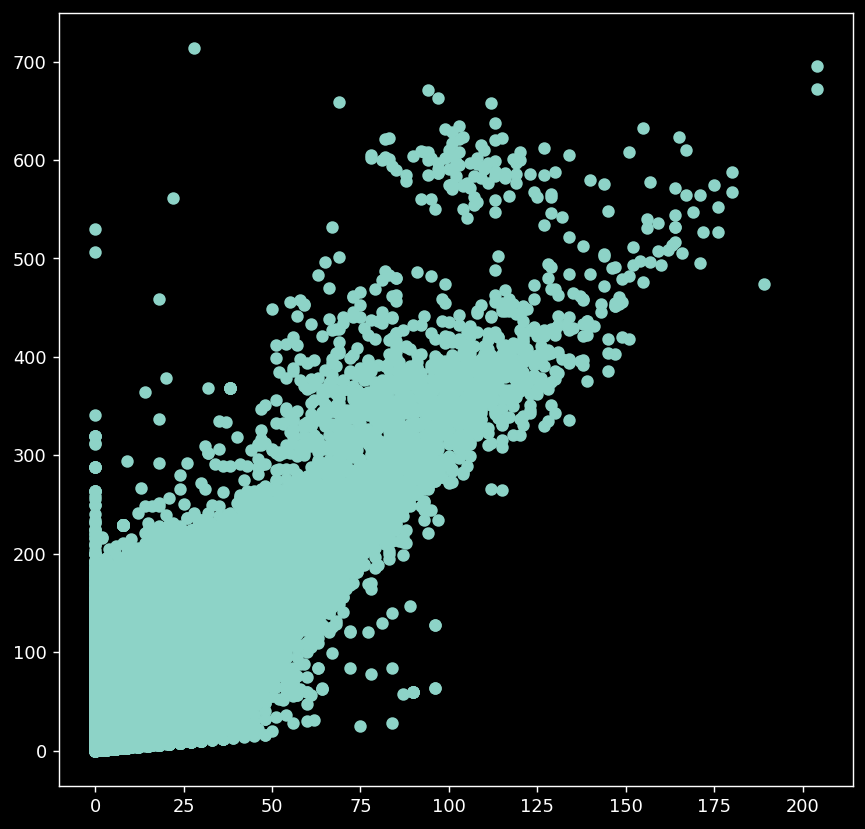

In [ ]:
import numpy
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(8, 8), dpi=128)
plt.scatter(vectors[:,0], vectors[:,1])
plt.show()
# plt.savefig('matplotlib.png')
# Interactive.
# plt.show()

# CLUSTERING

In [ ]:
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [ ]:
!pip install hdbscan

https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html#but-should-i-get-a-coffee

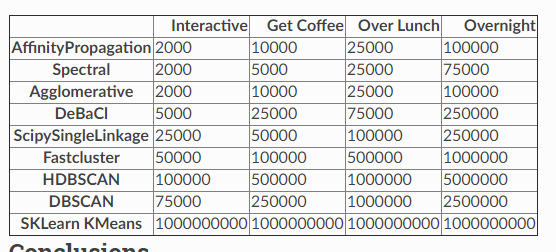

In [ ]:
string.lower()

(9881981, 2)

In [ ]:
# cluster_optics = OPTICS(min_samples=50000, max_eps=0.3, metric="cosine", n_jobs=-1).fit(vectors)

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(metric="")

In [ ]:
clusterer.fit(vectors)